# <h1><center><div class="alert alert-block alert-info"> Final Project - NYC Airbnb Listing  </div></center></h1>
 

In [1]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# suppress Pandas future warning 
import warnings
warnings.filterwarnings('ignore')

In [3]:
%autosave 20

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import rtree
import string
import math
import geopandas as gpd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_csv('AB_NYC_2019.csv')

In [6]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# <h1><center><div class="alert alert-block alert-info"> Dataset Description </div></center></h1>

In [7]:
df.shape

(48895, 16)

In [8]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [9]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

<div class="alert alert-block alert-success"> This dataset is <a href = "https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data"><font color=green>New York City Airbnb Open Data</font></a>, which lists activity and metrics in NYC, NY for 2019. This dataset contains 48,895 rows and 16 columns and it is a mix between categorical and numeric values.   $\;$ 


These columns include:</t>
<ul>
    <li>id:listing ID</li>
    <li>name: name of the listing</li>
    <li>host_id: host ID</li>
    <li>host_name: name of the host</li>
    <li>neighbourhood_group: location</li>
    <li>neighbourhood: area</li>
    <li>latitude: latitude coordinates</li>
    <li>longitude: longitude coordinates</li>
    <li>room_type: listing space type</li>
    <li>price: price in dollars</li>
    <li>minimum_nights: amount of nights minimum</li>
    <li>number_of_reviews: number of reviews</li>
    <li>last_review: latest review</li>
    <li>reviews_per_month: number of reviews per month</li>
    <li>calculated_host_listings_count: amount of listing per host</li>
    <li>availability_365: number of days when listing is available for booking</li>
</ul>
</div>

# <h1><center><div class="alert alert-block alert-info"> Data cleansing </div></center></h1>

### New York Airbnb Open Date

#### Deal with nan
* column 'name': drop rows with Nan
* column 'host_name': drop this colummn. 'host_id' provides enough information for host in our analysis
* column 'last_review': replace NaN with 'Unknown' and empty with 'Missing'
* column 'reviews_per_month': replace NaN with average monthly reviews

In [10]:
df.dropna(how = 'any', subset = ['name'], inplace = True)

In [11]:
df.drop(columns = ['host_name'], inplace = True)

In [12]:
df.last_review.fillna('Unknown', inplace = True)
df.last_review.replace(to_replace = '', value = 'Missing', inplace = True)

In [13]:
avg_monthly_reviews = df.reviews_per_month.mean()
df.reviews_per_month.fillna(avg_monthly_reviews, inplace = True)

#### Prepare the data for price analysis 

In [14]:
df1 = df.copy()

In [15]:
#have a stat knowledge about price
df1.price.describe()

count    48879.000000
mean       152.722355
std        240.186804
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [16]:
#Transfer column 'price' to be categorical % choose median as threshold
df1['price_factor'] = df1.price.apply(lambda x: 'low' if x <= 106 else 'high')

In [17]:
#also create a column stores binary values
df1['priceBin'] = (df1.price_factor == 'high') * 1.0

In [18]:
df1.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_factor,priceBin
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21000,6,365,high,1.0
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38000,2,355,high,1.0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,Unknown,1.37341,1,365,high,1.0
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64000,1,194,low,0.0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10000,1,0,low,0.0


#### Prepare the data for relationship between listing names and popularity analysis

In [19]:
#step 1: define unwanted characters
unwanted_char = ["a", "the", "an", "in", "to", "and", "with", "&", "of", "1", "2",\
                 "3", "4", "5", "6", "7", "8", "9", "0", "w", "on", "+", "|", "by", "from"]

#step 2: convert Series 'name' into a list
names = []
for name in df.name:
    names.append(name)

#step 3: lower case strings
names = str(names).lower()

#step 4: delete puntuations
names = "".join(i for i in str(names) if i not in ("?","!",",",";",":","/","-","_",".","#","'"))

#step 5: split string into word list
names = names.split()

#step 6: Define functions to remove words which contain unwanted char.
def check_unwanted_char_in_word(word, unwanted_char):
    """
    Check if any character in the unwanted_char list is present in each word of data
    """
    for char in unwanted_char:
        if char == word:
            return True
    return False

def check_char_in_list_of_word(data, unwanted_char):
    """
    Generate a boolean list checking each word in data whether that word contains unwanted_char
    """
    flags = []
    for word in data:
        in_flag = check_unwanted_char_in_word(word, unwanted_char)
        flags.append(in_flag)
    return flags

def remove_unwanted_char_from_list(data, unwanted_char):
    """
    Remove any word in data that has any of the char in unwanted_char through boolean list
    """
    in_flag = check_char_in_list_of_word(data, unwanted_char)
    remove_flag = [not i for i in in_flag]
    result = []
    for i in range(len(remove_flag)):
        if remove_flag[i] == True:
            result.append(data[i])   
    return result

In [20]:
names = remove_unwanted_char_from_list(names, unwanted_char)

In [21]:
df5 = df.copy()

In [22]:
#have a stat knowledge about price
df5.number_of_reviews.describe()

count    48879.000000
mean        23.281205
std         44.556149
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64

([<matplotlib.axis.XTick at 0x1a25f84e90>,
 <a list of 7 Text xticklabel objects>)

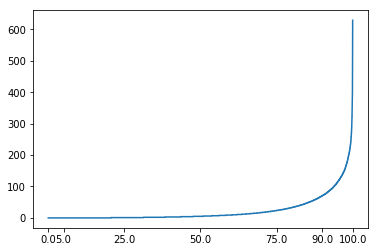

In [23]:
from matplotlib import mlab

d = np.sort(df5.number_of_reviews)
p = np.array([0.0, 5.0, 25.0, 50.0, 75.0, 90.0, 100.0])
plt.plot(d)
plt.xticks((len(d)-1) * p/100., map(str, p))
plt.show()


From the chart above, we have observed that at 90% percentile, there is a trend that the number of reviews start to go up significantly. Thus we chose the 90 percentile as the cut-off for popularity attribute for New York City listings.

In [24]:
df5.number_of_reviews.quantile(0.9)

70.0

In [25]:
#choose 90% as an threshold for being popular or not
df5['popular'] = df5.number_of_reviews.apply(lambda x: 0.0 if x <= 70 else 1.0)

#### Prepare the data for host analysis

In [26]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [27]:
df6 = df.copy()

In [28]:
#keep columns that will be used in our host analysis
df6.drop(columns = ['id','name','neighbourhood','last_review','latitude','longitude'],inplace = True)

In [29]:
df6.head()

,host_id,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Private room,149,1,9,0.21000,6,365
1,2845,Manhattan,Entire home/apt,225,1,45,0.38000,2,355
2,4632,Manhattan,Private room,150,3,0,1.37341,1,365
3,4869,Brooklyn,Entire home/apt,89,1,270,4.64000,1,194
4,7192,Manhattan,Entire home/apt,80,10,9,0.10000,1,0


In [30]:
#get dummies for KMeans later
df6 = pd.get_dummies(df6, columns = ['neighbourhood_group','room_type'])

In [31]:
df6.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,2787,149,1,9,0.21000,6,365,0,1,0,0,0,0,1,0
1,2845,225,1,45,0.38000,2,355,0,0,1,0,0,1,0,0
2,4632,150,3,0,1.37341,1,365,0,0,1,0,0,0,1,0
3,4869,89,1,270,4.64000,1,194,0,1,0,0,0,1,0,0
4,7192,80,10,9,0.10000,1,0,0,0,1,0,0,1,0,0


In [32]:
#drop column for KMeans later
df_clu = df6.drop(columns = ['host_id'])

In [33]:
df_clu.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,9,0.21000,6,365,0,1,0,0,0,0,1,0
1,225,1,45,0.38000,2,355,0,0,1,0,0,1,0,0
2,150,3,0,1.37341,1,365,0,0,1,0,0,0,1,0
3,89,1,270,4.64000,1,194,0,1,0,0,0,1,0,0
4,80,10,9,0.10000,1,0,0,0,1,0,0,1,0,0


In [34]:
#create a column stores binary values for later analysis
df6['pro'] = df6.calculated_host_listings_count.apply(lambda x: 1 if x>= 9 else 0)

In [35]:
df6.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,pro
0,2787,149,1,9,0.21000,6,365,0,1,0,0,0,0,1,0,0
1,2845,225,1,45,0.38000,2,355,0,0,1,0,0,1,0,0,0
2,4632,150,3,0,1.37341,1,365,0,0,1,0,0,0,1,0,0
3,4869,89,1,270,4.64000,1,194,0,1,0,0,0,1,0,0,0
4,7192,80,10,9,0.10000,1,0,0,0,1,0,0,1,0,0,0


### Supplement Data: NYC Geodata by Neigborhood

<a href = "https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq">Neighborhood Tabulation Areas Geodata(NTA)</a>

In [36]:
import geopandas as gpd
from shapely import wkt

In [37]:
#load NYC geodata
df_nh = pd.read_csv('nynta.csv')

In [38]:
df_nh.head()

,BoroCode,BoroName,the_geom,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07
1,4,Queens,MULTIPOLYGON (((-73.80379022888098 40.77561011...,81,QN51,Murray Hill,33266.904797,5.248828e+07
2,4,Queens,MULTIPOLYGON (((-73.8610972440186 40.763664477...,81,QN27,East Elmhurst,19816.712074,1.972685e+07
3,4,Queens,MULTIPOLYGON (((-73.75725671509139 40.71813860...,81,QN07,Hollis,20976.335574,2.288777e+07
4,1,Manhattan,MULTIPOLYGON (((-73.94607828674226 40.82126321...,61,MN06,Manhattanville,17040.685413,1.064708e+07


In [39]:
df_nh.rename(columns={'NTAName':'neighbourhood'}, inplace=True)

#convert the geometry column text into well known text in order to plot geometry correctly
df_nh['geometry'] = df_nh['the_geom'].apply(wkt.loads)

#convert the pandas dataframe into a Geopandas GeoDataFrame
df_nh = gpd.GeoDataFrame(df_nh, geometry='geometry')

In [40]:
df2 = df.copy()

#convert lat & long of Airbnb location into Point so that it enables the "data" dataframe to be a geopandas dataframe
df2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [41]:
#clean data a little bit by filtering data type
df2 = df2[df2.geometry.type == 'Point']
df_nh = df_nh[df_nh.geometry.type == 'MultiPolygon']

### Supplement Data: NYC Criminal Complaints Data

<a href = "https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243">NYPD Complaint Data Current (Year To Date) Geodata</a>

In [42]:
#load NYC 2019 complaints data
df_ytd = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_.csv')

In [43]:
df_ytd.shape
df_ytd.head()

(461711, 35)

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,314773184,48,BRONX,12/31/19,18:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)"
1,289837961,25,MANHATTAN,12/30/19,20:30:00,12/31/19,10:00:00,COMPLETED,NaN,NaN,...,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
2,535744284,77,BROOKLYN,12/24/19,16:55:00,12/24/19,17:00:00,COMPLETED,NaN,NaN,...,M,NaN,18-24,WHITE,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)"
3,895678119,52,BRONX,12/30/19,19:32:00,NaN,NaN,COMPLETED,NaN,NaN,...,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)"
4,299841674,18,MANHATTAN,12/30/19,15:30:00,12/30/19,16:50:00,COMPLETED,NaN,NaN,...,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"


In [44]:
#keep useful columns
df_ytd = df_ytd[['BORO_NM', 'CMPLNT_FR_DT', 'Latitude', 'Longitude', 'Lat_Lon']]

In [45]:
#only need data in 2019
df_ytd['year'] = pd.DatetimeIndex(df_ytd['CMPLNT_FR_DT']).year
df_ytd = df_ytd[df_ytd.year >= 2019]

In [46]:
df_ytd.dropna(subset = ['BORO_NM'], inplace=True)

In [47]:
#convert data into geodataframe
df3 = gpd.GeoDataFrame(df_ytd, geometry=gpd.points_from_xy(df_ytd.Longitude, df_ytd.Latitude))

In [48]:
#clean geodata
df3 = df3[df3.geometry.type == 'Point']

### Supplement Data: NYC Museums and Places of Interest Data

<a href = "https://data.ny.gov/dataset/Areas_of_Interest_Centroids/ssdk-4qjy">Areas_of_Interest_Centroids</a>    $\;$

<a href = "https://data.cityofnewyork.us/Recreation/New-York-City-Museums/ekax-ky3z">New York City Museums</a>

We combined NYC Musenms and  Places of Interest Data together to represent scenic landmarks in NYC

In [49]:
df_int = pd.read_csv('Areas_of_Interest_Centroids.csv')

In [50]:
df_int.head()

,the_geom,OBJECTID,Id,Name,Stacked,AnnoLine1,AnnoLine3,Borough,AnnoLine4,AnnoLine2a,Angle
0,POINT (-73.88895811640342 40.8962098695574),1,90,Van Cortlandt Park,3,Van,Park,Bronx,NaN,Cortlandt,0
1,POINT (-73.87165102682086 40.88987947152594),2,95,Woodlawn Cemetery,2,Woodlawn,NaN,Bronx,NaN,Cemetery,0
2,POINT (-73.8386418872537 40.88696522165708),3,81,Seton Falls Park,3,Seton,Park,Bronx,NaN,Falls,0
3,POINT (-73.80980242290379 40.87798554992497),4,69,Pelham Bay Park,3,Pelham,Park,Bronx,NaN,Bay,0
4,POINT (-73.87830775950145 40.864423947038276),5,8,Botanical Garden,2,Botanical,NaN,Bronx,NaN,Garden,0


In [51]:
df_int.shape
df_int.isna().any()

(96, 11)

the_geom      False
OBJECTID      False
Id            False
Name          False
Stacked       False
AnnoLine1     False
AnnoLine3      True
Borough       False
AnnoLine4      True
AnnoLine2a     True
Angle         False
dtype: bool

Since we only need the location, column'the_geom' in our data analysis, we did not deal with na in column 'AnnoLine3', 'Annoline4' and 'AnnoLine2a'

In [52]:
df_m = pd.read_csv('MUSEUM.csv')

In [53]:
df_m.head()

,the_geom,NAME,TEL,URL,ADRESS1,ADDRESS2,CITY,ZIP
0,POINT (-74.01375579519738 40.703816216918035),Alexander Hamilton U.S. Custom House,(212) 514-3700,http://www.oldnycustomhouse.gov/,1 Bowling Grn,NaN,New York,10004
1,POINT (-74.06303178855111 40.615120837755356),Alice Austen House Museum,(718) 816-4506,http://www.aliceausten.org/,2 Hylan Blvd,NaN,Staten Island,10305
2,POINT (-73.94729768541572 40.833853500753314),American Academy of Arts and Letters,(212) 368-5900,http://www.artsandletters.org/,633 W. 155th St.,NaN,New York,10032
3,POINT (-73.97810302110001 40.76162497138548),American Folk Art Museum,(212) 265-1040,http://www.folkartmuseum.org/,45 West 53rd Street,NaN,New York,10019
4,POINT (-74.0396848374904 40.69905626244391),American Immigration History Center,(212) 363-3200,http://www.ellisisland.org/,Ellis Island,NaN,New York,0


In [54]:
df_m.shape
df_m.isna().any()

(130, 8)

the_geom    False
NAME        False
TEL          True
URL         False
ADRESS1     False
ADDRESS2     True
CITY        False
ZIP         False
dtype: bool

Since we only need the location, column'the_geom' in our data analysis, we did not deal with na in column 'TEL'and 'ADDRESS2'

In [55]:
#merge two dataframes above to get location information of scenic landmarks in NYC
df_scene = df_int.merge(df_m, how = 'outer')

In [56]:
df_scene.shape

(226, 18)

In [57]:
#drop any duplicates in the table if any
df_scene.drop_duplicates(subset='the_geom',inplace = True)

In [58]:
df_scene.shape

(226, 18)

In [59]:
df_scene.the_geom.isna().any()

False

In [60]:
#same steps as previous geodata
df_scene['geometry'] = df_scene['the_geom'].apply(wkt.loads)
df_scene = gpd.GeoDataFrame(df_scene, geometry='geometry')
df_scene = df_scene[df_scene.geometry.type == 'Point']

In [61]:
df_scene.head()

,the_geom,OBJECTID,Id,Name,Stacked,AnnoLine1,AnnoLine3,Borough,AnnoLine4,AnnoLine2a,Angle,NAME,TEL,URL,ADRESS1,ADDRESS2,CITY,ZIP,geometry
0,POINT (-73.88895811640342 40.8962098695574),1.0,90.0,Van Cortlandt Park,3.0,Van,Park,Bronx,NaN,Cortlandt,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.88896 40.89621)
1,POINT (-73.87165102682086 40.88987947152594),2.0,95.0,Woodlawn Cemetery,2.0,Woodlawn,NaN,Bronx,NaN,Cemetery,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.87165 40.88988)
2,POINT (-73.8386418872537 40.88696522165708),3.0,81.0,Seton Falls Park,3.0,Seton,Park,Bronx,NaN,Falls,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.83864 40.88697)
3,POINT (-73.80980242290379 40.87798554992497),4.0,69.0,Pelham Bay Park,3.0,Pelham,Park,Bronx,NaN,Bay,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.80980 40.87799)
4,POINT (-73.87830775950145 40.864423947038276),5.0,8.0,Botanical Garden,2.0,Botanical,NaN,Bronx,NaN,Garden,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.87831 40.86442)


### Supplement Data: SF Airbnb Data

<a href = "https://www.kaggle.com/jeploretizo/san-francisco-airbnb-listings">SF Airbnb</a> 

In [62]:
df_sf = pd.read_csv('listings.csv')

In [63]:
pd.set_option('display.max_columns', None)

In [64]:
# select the columns same as that in NY Airbnb dataset
df_sf = df_sf[['name','neighbourhood_cleansed','calculated_host_listings_count','latitude','longitude',\
       'room_type','price','availability_365','minimum_nights','number_of_reviews','reviews_per_month']]

In [65]:
df_sf.head()

,name,neighbourhood_cleansed,calculated_host_listings_count,latitude,longitude,room_type,price,availability_365,minimum_nights,number_of_reviews,reviews_per_month
0,"Bright, Modern Garden Unit - 1BR/1B",Western Addition,1,37.76931,-122.43386,Entire home/apt,$170.00,85,1,217,1.74
1,Charming room for two,Inner Sunset,3,37.75402,-122.45805,Private room,$99.00,62,1,160,1.28
2,Creative Sanctuary,Bernal Heights,1,37.74511,-122.42102,Entire home/apt,$235.00,0,30,111,0.87
3,A Friendly Room - UCSF/USF - San Francisco,Haight Ashbury,9,37.76669,-122.45250,Private room,$65.00,365,32,18,0.15
4,Friendly Room Apt. Style -UCSF/USF - San Franc...,Haight Ashbury,9,37.76487,-122.45183,Private room,$65.00,365,32,8,0.13


In [66]:
df_sf.isna().sum()

name                                 0
neighbourhood_cleansed               0
calculated_host_listings_count       0
latitude                             0
longitude                            0
room_type                            0
price                                0
availability_365                     0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 1605
dtype: int64

Clean SF data in the same way as NYC airbnb data

In [67]:
#fillna with avg monthly reviews
avg_sf_monthly_reviews = df_sf.reviews_per_month.mean()
df_sf.reviews_per_month.fillna(avg_sf_monthly_reviews, inplace = True)

In [68]:
#choose threshold for being popular or not
df_sf.number_of_reviews.describe()

count    8111.000000
mean       45.203181
std        78.437987
min         0.000000
25%         1.000000
50%        10.000000
75%        54.000000
max       757.000000
Name: number_of_reviews, dtype: float64

([<matplotlib.axis.XTick at 0x1a307fa950>,
 <a list of 7 Text xticklabel objects>)

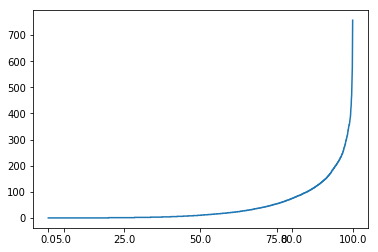

In [69]:
d = np.sort(df_sf.number_of_reviews)
p = np.array([0.0, 5.0, 25.0, 50.0, 75.0, 80.0, 100.0])
plt.plot(d)
plt.xticks((len(d)-1) * p/100., map(str, p))
plt.show()


From the chart above, we have observed that at 80% percentile, there is a trend that the number of reviews start to go up significantly. Thus we chose the 80 percentile as the cut-off for popularity attribute for San Francisco listings.

In [70]:
#use 80% as threshold to create binary values
df_sf.number_of_reviews.quantile(0.80)

74.0

In [71]:
df_sf['popular'] = df_sf.number_of_reviews.apply(lambda x: 0.0 if x <= 74 else 1.0)

# <h1><center><div class="alert alert-block alert-info"> Interesting fact 1 - Price analysis </div></center></h1>

We want to know how differet attributes that can affect the price of Airbnb's listings

### 1. Room Type vs Price

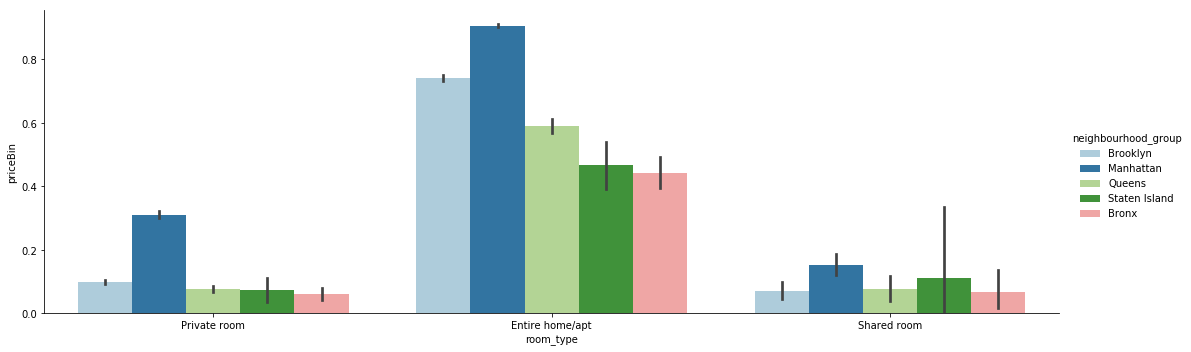

In [72]:
with sns.color_palette("Paired"):
    sns.catplot(x = 'room_type', y = 'priceBin',data = df1,hue = 'neighbourhood_group', kind = 'bar', aspect = 3)

Within our expectation, prices of entire homes are the highest and listings in Manhattan usually have higher price. For Staten Island, the variance of price is very high, based on the length of the barplot.

### 2. Seasonality vs Price

In [73]:
df1_temp = df1[(df1.last_review != 'Missing') & (df1.last_review != 'Unknown')]

In [74]:
#create 'Year','Month'columns for later analysis
df1_temp['Date'] = pd.to_datetime(df1_temp.last_review)
df1_temp['Month'] = df1_temp['Date'].dt.strftime('%b')
df1_temp['Year'] = df1_temp['Date'].dt.strftime('%Y')

#reset the order of month 
cats = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df1_temp['Month'] = pd.Categorical(df1_temp['Month'], ordered=True, categories=cats)

In [75]:
# remove outliers, use 99% as threshold
df1_temp.price.quantile(q = 0.99)

671.2799999999988

In [76]:
df_p_y = df1_temp[df1_temp.price <= 671].groupby('Year')['price'].mean().reset_index()
df_p_y

,Year,price
0,2011,169.000000
1,2012,135.541667
2,2013,155.276596
3,2014,151.683673
4,2015,132.112163
5,2016,127.604878
6,2017,121.610954
7,2018,127.136515
8,2019,132.949293


<Figure size 1080x432 with 0 Axes>

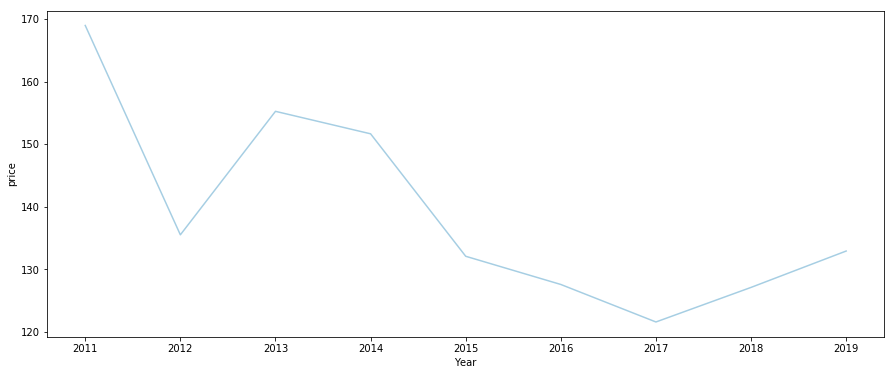

In [77]:
plt.figure(figsize = (15,6))
with sns.color_palette("Paired"):
    sns.lineplot(x = 'Year', y = 'price', data = df_p_y)

The plot above shows price with its varianace in the previous decade.

In [78]:
df_p_m = df1_temp[df1_temp.price <= 671].groupby('Month')['price'].mean().reset_index()
df_p_m

,Month,price
0,Jan,128.301535
1,Feb,114.763298
2,Mar,122.142745
3,Apr,129.694818
4,May,128.581110
5,Jun,133.326608
6,Jul,133.111205
7,Aug,124.295152
8,Sep,125.883752
9,Oct,131.406658


<Figure size 1080x432 with 0 Axes>

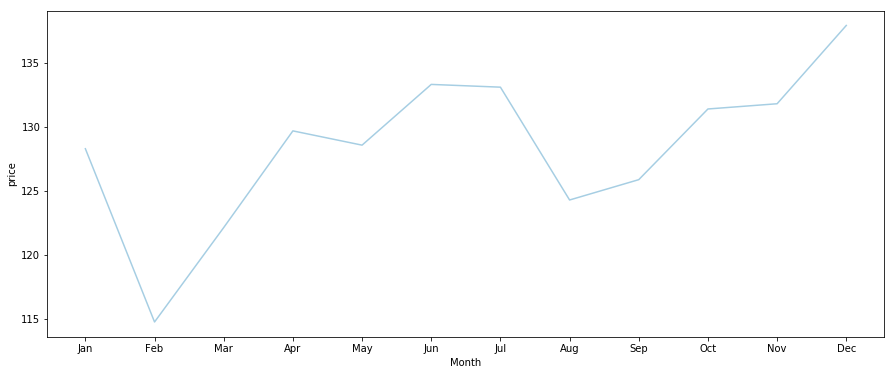

In [79]:
plt.figure(figsize = (15,6))
with sns.color_palette("Paired"):
    sns.lineplot(x = 'Month', y = 'price', data = df_p_m)

The plot above shows price with its varianace in each month, aggregated by data from last decade.

The observation is that average price has been decreasing from 2011 to 2017. Price began to increase since 2017. The downward trend between 2011 and 2017 may result from Airbnb's business expansion and marketing promotion. since 2017, the increase of price may due to branding image upgrade and increased market share of Airbnb.  
Price has two peaks during the year, one lies in summer time (April-July) and the other lies in winter time (December), which makes sense because of summer vacation time and winter holiday season.

### 3. Boroughs vs Price

At first, we want to check how the neighorhood group relates to price of Airbnb listings 

<Figure size 1080x432 with 0 Axes>

(0, 700)

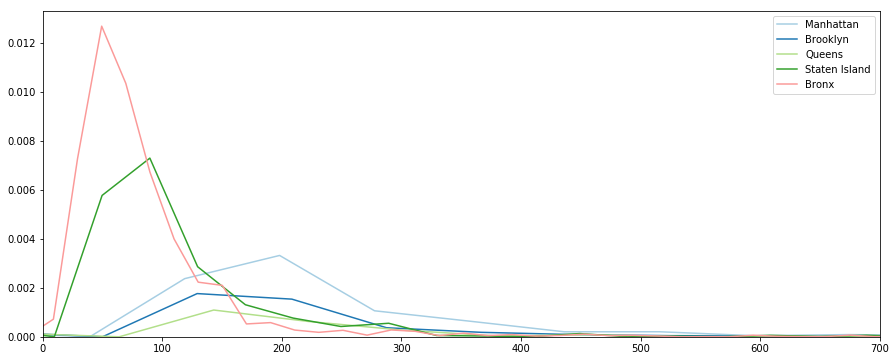

In [80]:
plt.figure(figsize=(15,6))
with sns.color_palette("Paired"):
    sns.kdeplot(df[df.neighbourhood_group=='Manhattan'].price,label='Manhattan')
    sns.kdeplot(df[df.neighbourhood_group=='Brooklyn'].price,label='Brooklyn')
    sns.kdeplot(df[df.neighbourhood_group=='Queens'].price,label='Queens')
    sns.kdeplot(df[df.neighbourhood_group=='Staten Island'].price,label='Staten Island')
    sns.kdeplot(df[df.neighbourhood_group=='Bronx'].price,label='Bronx')
    plt.xlim(0,700)

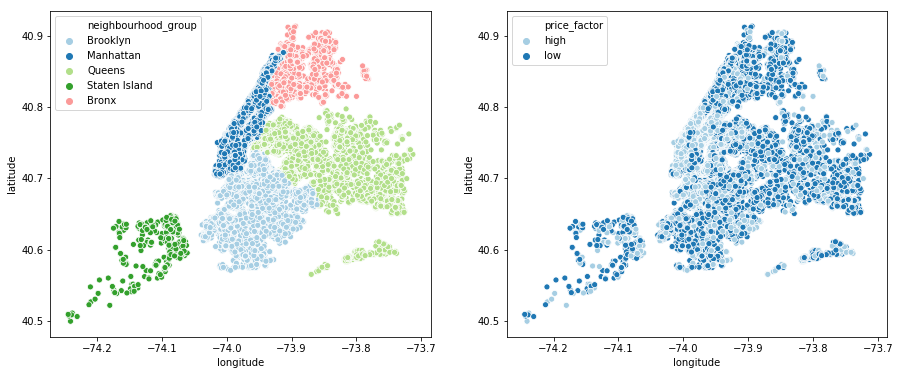

In [81]:
# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 6))
with sns.color_palette("Paired"):
    sns.scatterplot(df1.longitude,df1.latitude,hue=df1.price_factor, ax=axes[1])
    sns.scatterplot(df1.longitude,df1.latitude,hue=df1.neighbourhood_group, ax=axes[0])
    plt.ioff()

Two plots above show that: 

Most of Airbnb listings in NYC are priced less than 300, across all neighborhood groups. There is rarely any listings that are priced under $106 in Manhattan while there is ample supply of low-price listings in Bronx. Meanwhile, Brooklyn, Queens, and Staten Island have a fair split of high and low-priced listings.

Obviously, price analysis on the neigborhood group level can not provide enough information for us. Therefore, we digged into the next level, from neigborhood group to neighborhood, to conduct further analysis.

### In-depth analysis - Utilizing other data to further analyzing

First, look at the price of each neighborhood.

In [82]:
#sjoin can do intersect analysis to find which neighborhood the Airbnb location is in NYC geodata
df_spatial = gpd.sjoin(df_nh, df2, how='inner', op='intersects')

In [83]:
df_spatial.head()

,BoroCode,BoroName,the_geom,CountyFIPS,NTACode,neighbourhood_left,Shape_Leng,Shape_Area,geometry,index_right,id,name,host_id,neighbourhood_group,neighbourhood_right,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",36358,28918768,living room space but with curtain for privacy,35927005,Brooklyn,Borough Park,40.63522,-74.00596,Shared room,35,1,0,Unknown,1.37341,10,352
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",40039,31090803,Clean & Nice & Affordable 3-P Room/Private Bath,216772639,Brooklyn,Borough Park,40.63529,-74.00618,Private room,48,1,2,2019-05-27,0.91000,7,169
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",36156,28738642,4th Floor en-suite Bath Room,216772639,Brooklyn,Borough Park,40.63378,-74.00599,Private room,60,1,7,2019-06-04,0.76000,7,179
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",36356,28918405,Nice Couple in A Walk in Basement with Window,35927005,Brooklyn,Borough Park,40.63416,-74.00722,Private room,50,2,0,Unknown,1.37341,10,365
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",20140,16134738,Brooklyn Bedroom Near Subway with Washer/Dryer,9372363,Brooklyn,Borough Park,40.61426,-73.97746,Private room,65,3,8,2019-06-18,0.26000,2,40


In [84]:
df_spatial.drop(columns='geometry', inplace=True)

#Rename the column. 
df_spatial.rename(columns={'neighbourhood_left':'neighbourhood'}, inplace=True)

In [85]:
#Create a avg price of each neighborhood
nh_avg_price = df_spatial.groupby('neighbourhood')['price'].mean().reset_index()

In [86]:
#merge avg price of neighbourhood with NYC geodata
nh_avg_price = df_nh.merge(nh_avg_price, on='neighbourhood')

Text(0.5,1,'Average Price by Neighborhood in NYC')

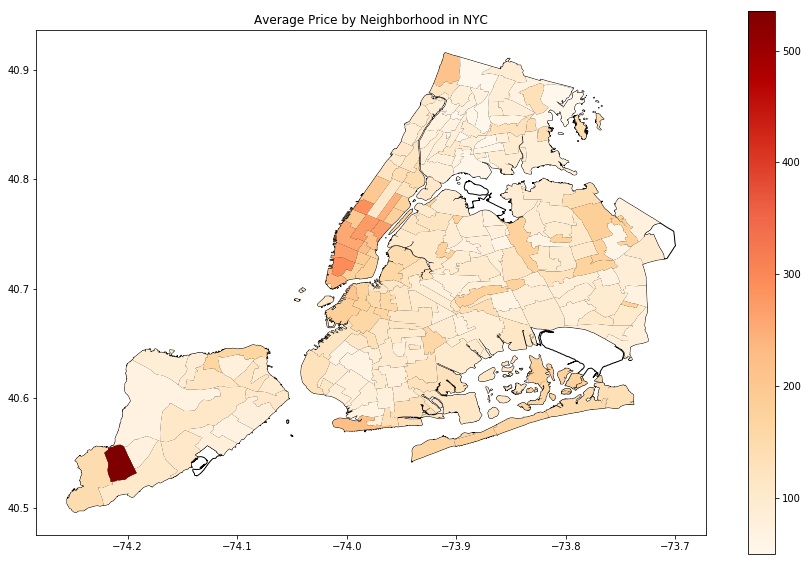

In [87]:
#Lets plot the data
fig,ax = plt.subplots(1,1, figsize=(15,10))

base = df_nh.plot(color='white', edgecolor='black', ax=ax)

nh_avg_price.plot(column='price',cmap='OrRd', ax=base, legend=True)
plt.title('Average Price by Neighborhood in NYC')

Apart from high-priced listings in Manhattan, listings in a few neigborhood at Staten Island also have extremely high price. This is totally unexpected considering that Staten Island is far from the New York city downtown and a large ratio of the listings there have low price. Let's see why.

In [88]:
df[df.neighbourhood_group == 'Staten Island'].groupby('neighbourhood')['price'].mean().nlargest(5)

neighbourhood
Fort Wadsworth    800.0
Woodrow           700.0
Prince's Bay      409.5
Randall Manor     336.0
Willowbrook       249.0
Name: price, dtype: float64

In [89]:
df[(df.neighbourhood == 'Fort Wadsworth') | (df.neighbourhood == 'Woodrow') | (df.neighbourhood == "Prince's Bay")]\
[['name','neighbourhood_group','neighbourhood','room_type','price']]

,name,neighbourhood_group,neighbourhood,room_type,price
3049,Spacious center hall colonial,Staten Island,Woodrow,Entire home/apt,700
18444,Cute Lofted Apt.,Staten Island,Prince's Bay,Entire home/apt,185
25386,Beach House Retreat. 15 minutes from Manhattan.,Staten Island,Fort Wadsworth,Entire home/apt,800
34159,Anna's place bed and breakfast,Staten Island,Prince's Bay,Private room,118
43687,Cozy farmhouse in NYC. 2 bdrms; 2 full baths. ...,Staten Island,Prince's Bay,Entire home/apt,85
45572,Central Hall Colonial with Free Parking Bus EX...,Staten Island,Prince's Bay,Entire home/apt,1250


It turns out that these listings are either of central hall colonial style or beach houses. Typically, these two kinds of properties have large lot size with particularly luxary design. Given that these kinds of properties usually have bigger number of rooms and target large groups. It helps explain why they are listed with high price on Airbnb even far from New York downtown area and why the variance of listing price in Staten Island is also high.

### 1. Number of Criminal Cases by Neighborhood in NYC

In [90]:
#join crime data with NYC geodata
df_ytd_spatial = gpd.sjoin(df_nh, df3, how='inner', op='intersects')

In [91]:
df_ytd_spatial.head()

,BoroCode,BoroName,the_geom,CountyFIPS,NTACode,neighbourhood,Shape_Leng,Shape_Area,geometry,index_right,BORO_NM,CMPLNT_FR_DT,Latitude,Longitude,Lat_Lon,year
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",84099,BROOKLYN,10/31/19,40.638847,-73.986356,"(40.63884739100007, -73.98635632199995)",2019
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",151303,BROOKLYN,9/5/19,40.639235,-73.987751,"(40.63923456300005, -73.987750669)",2019
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",340719,BROOKLYN,4/9/19,40.639235,-73.987751,"(40.63923456300005, -73.987750669)",2019
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",155569,BROOKLYN,9/8/19,40.639235,-73.987751,"(40.63923456300005, -73.987750669)",2019
0,3,Brooklyn,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",406562,BROOKLYN,2/19/19,40.639794,-73.987167,"(40.639794436000045, -73.98716684799997)",2019


In [92]:
df_ytd_spatial.drop(columns='geometry', inplace=True)

#Create a criminal count of each neighborhood
cr_count = df_ytd_spatial.groupby('neighbourhood').count().reset_index()[['neighbourhood', 'BoroCode']]
cr_count.rename(columns = {'BoroCode':'count'},inplace = True)

In [93]:
cr_count = df_nh.merge(cr_count, on='neighbourhood')

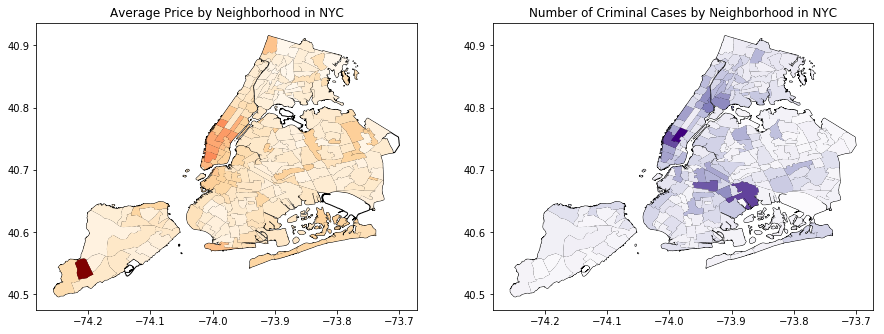

In [94]:
#Lets plot the data
fig,ax = plt.subplots(1,2, figsize=(15,15))

base1 = df_nh.plot(color='white', edgecolor='black', ax=ax[0])
base2 = df_nh.plot(color='white', edgecolor='black', ax=ax[1])
ax1 = nh_avg_price.plot(column='price',cmap='OrRd', ax=base1)
ax2 = cr_count.plot(column='count',cmap='Purples', ax=base2)

ax1.title.set_text('Average Price by Neighborhood in NYC')
ax2.title.set_text('Number of Criminal Cases by Neighborhood in NYC')


From the map above, we observe that Airbnb listings in neigborhood with a high number of criminal cases usually have lower price. However, there are a few neigborhoods have both high listing price and criminal cases. This is not within our expectation. We would like to proceed with further analysis here.

In [95]:
top_20_p = nh_avg_price[['neighbourhood','price']].nlargest(20, columns = 'price')
top_20_p.head()

,neighbourhood,price
104,Rossville-Woodrow,535.750000
120,SoHo-TriBeCa-Civic Center-Little Italy,293.216080
80,Lincoln Square,289.431579
81,Midtown-Midtown South,274.216216
164,Turtle Bay-East Midtown,270.930206


In [96]:
top_20_c = cr_count[['neighbourhood','count']].nlargest(20, columns = 'count')
top_20_c.rename(columns={'count':'n_crime'}, inplace = True)
top_20_c.head()

,neighbourhood,n_crime
83,Midtown-Midtown South,11168
110,East New York,8861
126,Hudson Yards-Chelsea-Flatiron-Union Square,8586
29,Crown Heights North,8158
179,East Harlem North,7016


In [97]:
#find out the overlapping between neigborhoods with top 20 criminal cases and neigborhoods with top 20 high prices
top_pc = top_20_p.merge(top_20_c, how='inner')
top_pc

,neighbourhood,price,n_crime
0,SoHo-TriBeCa-Civic Center-Little Italy,293.216080,5262
1,Midtown-Midtown South,274.216216,11168
2,West Village,269.262019,5145
3,Hudson Yards-Chelsea-Flatiron-Union Square,257.807122,8586
4,Upper West Side,200.983830,5332
5,Clinton,199.130615,5043


Based on the analysis above, among top 20 neigborhood with highest crimial cases, 6 of them also have top 20 highest price on the Airbnb. Again, this is not what we would expect. Why would the host list their properties with higher price in comparably unsafe neigborhood? Why would customers choose these listings anyway?

### 2. Area of Interest and Museums by neigborhood

In [98]:
df_scene_spatial = gpd.sjoin(df_nh, df_scene, how='inner', op='intersects')

In [99]:
df_scene_spatial.head()

,BoroCode,BoroName,the_geom_left,CountyFIPS,NTACode,neighbourhood,Shape_Leng,Shape_Area,geometry,index_right,the_geom_right,OBJECTID,Id,Name,Stacked,AnnoLine1,AnnoLine3,Borough,AnnoLine4,AnnoLine2a,Angle,NAME,TEL,URL,ADRESS1,ADDRESS2,CITY,ZIP
7,2,Bronx,MULTIPOLYGON (((-73.78833349834532 40.83466712...,5,BX10,Pelham Bay-Country Club-City Island,138249.436420,4.013453e+07,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ...",11,POINT (-73.76975723964243 40.851364969267536),12.0,42.0,Hart Island,2.0,Hart,NaN,Bronx,NaN,Island,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,Bronx,MULTIPOLYGON (((-73.83979488496121 40.83561920...,5,BX52,Schuylerville-Throgs Neck-Edgewater Park,91304.794869,8.843996e+07,"MULTIPOLYGON (((-73.83979 40.83562, -73.83967 ...",61,POINT (-73.79311970418817 40.8056466984195),62.0,33.0,Fort Schuyler,2.0,Fort,NaN,Bronx,NaN,Schuyler,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,Bronx,MULTIPOLYGON (((-73.83979488496121 40.83561920...,5,BX52,Schuylerville-Throgs Neck-Edgewater Park,91304.794869,8.843996e+07,"MULTIPOLYGON (((-73.83979 40.83562, -73.83967 ...",7,POINT (-73.83284639755986 40.814343380069246),8.0,27.0,Ferry Point Park,3.0,Ferry,Park,Bronx,NaN,Point,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2,Bronx,MULTIPOLYGON (((-73.83979488496121 40.83561920...,5,BX52,Schuylerville-Throgs Neck-Edgewater Park,91304.794869,8.843996e+07,"MULTIPOLYGON (((-73.83979 40.83562, -73.83967 ...",6,POINT (-73.83530397142964 40.82330814715979),7.0,78.0,Saint Raymond's Cemetery,3.0,St.,Cemetery,Bronx,NaN,Raymond's,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,4,Queens,MULTIPOLYGON (((-73.75205066516907 40.70522802...,81,QN08,St. Albans,45401.316951,7.741275e+07,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",43,POINT (-73.77202424502954 40.68791058817667),44.0,76.0,Roy Wilkins Park,3.0,Roy,Park,Queens,NaN,Wilkins,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df_scene_spatial.columns

Index(['BoroCode', 'BoroName', 'the_geom_left', 'CountyFIPS', 'NTACode',
       'neighbourhood', 'Shape_Leng', 'Shape_Area', 'geometry', 'index_right',
       'the_geom_right', 'OBJECTID', 'Id', 'Name', 'Stacked', 'AnnoLine1',
       'AnnoLine3', 'Borough', 'AnnoLine4', 'AnnoLine2a', 'Angle', 'NAME',
       'TEL', 'URL', 'ADRESS1', 'ADDRESS2', 'CITY', 'ZIP'],
      dtype='object')

In [101]:
df_scene_spatial.drop(columns='geometry', inplace=True)

In [102]:
#count based on neighborhood group
scene_count = df_scene_spatial.groupby('neighbourhood').count().reset_index()[['neighbourhood', 'BoroCode']]
scene_count.rename(columns = {'BoroCode':'count'},inplace = True)

In [103]:
scene_count = df_nh.merge(scene_count, on='neighbourhood')

In [104]:
scene_count.head(2)

,BoroCode,BoroName,the_geom,CountyFIPS,NTACode,neighbourhood,Shape_Leng,Shape_Area,geometry,count
0,2,Bronx,MULTIPOLYGON (((-73.78833349834532 40.83466712...,5,BX10,Pelham Bay-Country Club-City Island,138249.436420,4.013453e+07,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ...",1
1,2,Bronx,MULTIPOLYGON (((-73.83979488496121 40.83561920...,5,BX52,Schuylerville-Throgs Neck-Edgewater Park,91304.794869,8.843996e+07,"MULTIPOLYGON (((-73.83979 40.83562, -73.83967 ...",3


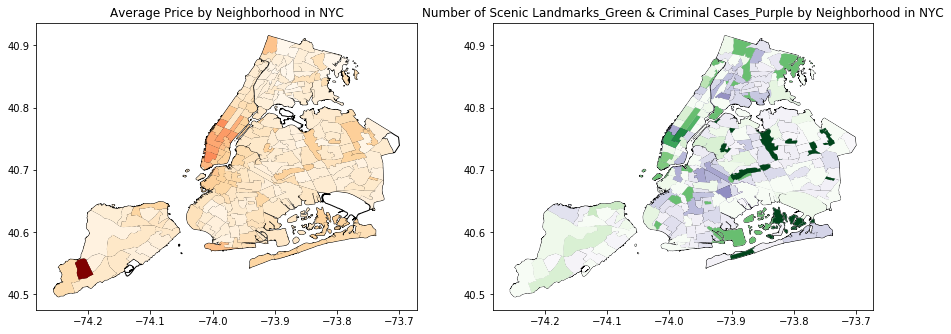

In [105]:
#Lets plot the data
fig,ax = plt.subplots(1,2, figsize=(15,15))

base1 = df_nh.plot(color='white', edgecolor='black', ax=ax[0])
base2 = df_nh.plot(color='white', edgecolor='black', ax=ax[1])


ax1 = nh_avg_price.plot(column='price',cmap='OrRd', ax=base1)
ax2 = cr_count.plot(column='count',cmap='Purples', ax=base2)
ax3 = scene_count.plot(column='count',cmap='Greens', ax=base2)

ax1.title.set_text('Average Price by Neighborhood in NYC')
ax2.title.set_text('Number of Scenic Landmarks_Green & Criminal Cases_Purple by Neighborhood in NYC')



With the graph above, a hypothesis is that there are some overlapping between neigborhoods with a high number of criminal cases and neigborhoods with lots of scenic landmarks.

In [106]:
# we excluded 'park' neighborhood since there will not be any airbnb in the park
scene_count['park']= scene_count.neighbourhood.apply(lambda x: 0 if x.startswith('park') else 1)

In [107]:
top_10_s = scene_count[scene_count.park == 1][['neighbourhood','count']].nlargest(10, columns = 'count')
top_10_s.rename(columns={'count':'n_scene'}, inplace = True)
top_10_s

,neighbourhood,n_scene
21,Midtown-Midtown South,14
41,Hudson Yards-Chelsea-Flatiron-Union Square,12
22,Upper East Side-Carnegie Hill,11
19,Battery Park City-Lower Manhattan,9
38,SoHo-TriBeCa-Civic Center-Little Italy,9
56,Washington Heights South,6
78,West New Brighton-New Brighton-St. George,5
18,Annadale-Huguenot-Prince's Bay-Eltingville,4
42,Upper West Side,4
53,Murray Hill-Kips Bay,4


In [108]:
top_pc.merge(top_10_s, how='inner', on = 'neighbourhood')

,neighbourhood,price,n_crime,n_scene
0,SoHo-TriBeCa-Civic Center-Little Italy,293.216080,5262,9
1,Midtown-Midtown South,274.216216,11168,14
2,Hudson Yards-Chelsea-Flatiron-Union Square,257.807122,8586,12
3,Upper West Side,200.983830,5332,4


The table above proves our hypothesis above. Four of the six neigborhoods that have high average listing prices and high criminal cases are also in the top 10 neigborhoods that have highest number of scenic landmarks. Customers value the convenience towards these locations.

<div class="alert alert-block alert-success">
<blockquote>
<p> Conclusion:   
<ul>
For the neigborhood in the vincinity of scenic landmarks, Airbnb are less sensitive to the criminal case number when visiting New York City.
    
</ul>
</p>
</blockquote>
<blockquote>
<p> 
Managerial Suggestion:  
<ul>
It is recommended that the managerial team prioritizes introducing and/or acquiring listings that are close to places of interest in order to maximize potential revenue generated by the listings. 
</ul>
</p>  
</blockquote>
</div>

# <h1><center><div class="alert alert-block alert-info"> Interesting Fact 2 - Listing name analysis </div></center></h1>

For the second part, we would like to explore what is the relationship between listing names and the popularity of Airbnb listings in New York City, considering that it is usually the listing names that leave the first impression for the Airbnb customers.

### Take a glance at the listing names

In [109]:
from collections import Counter

In [110]:
# Find the most commonly used word in the NYC Airbnb's listing name
names_most = Counter(names).most_common(30)

In [111]:
names_most = pd.DataFrame(names_most).rename(columns={0:'Words', 1:'Count'})

In [112]:
names_most.head()

,Words,Count
0,room,9933
1,bedroom,7570
2,private,7069
3,apartment,6629
4,cozy,4939


<Figure size 1080x432 with 0 Axes>

[Text(0,0,'room'),
 Text(0,0,'bedroom'),
 Text(0,0,'private'),
 Text(0,0,'apartment'),
 Text(0,0,'cozy'),
 Text(0,0,'apt'),
 Text(0,0,'brooklyn'),
 Text(0,0,'studio'),
 Text(0,0,'spacious'),
 Text(0,0,'manhattan'),
 Text(0,0,'park'),
 Text(0,0,'east'),
 Text(0,0,'sunny'),
 Text(0,0,'williamsburg'),
 Text(0,0,'beautiful'),
 Text(0,0,'near'),
 Text(0,0,'village'),
 Text(0,0,'nyc'),
 Text(0,0,'heart'),
 Text(0,0,'large'),
 Text(0,0,'loft'),
 Text(0,0,'home'),
 Text(0,0,'modern'),
 Text(0,0,'central'),
 Text(0,0,'bright'),
 Text(0,0,'luxury'),
 Text(0,0,'1br'),
 Text(0,0,'west'),
 Text(0,0,'location'),
 Text(0,0,'new')]

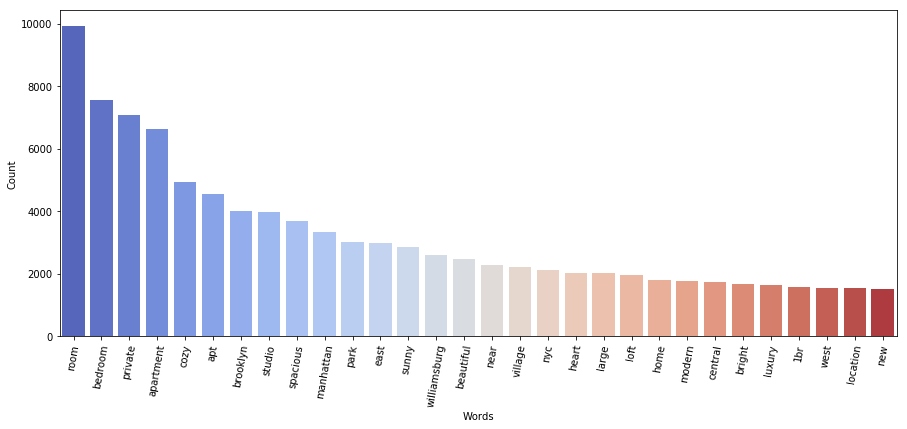

In [113]:
plt.figure(figsize = (15,6))
with sns.color_palette("coolwarm", 30):
    plot1 = sns.barplot(x = 'Words', y = 'Count', data = names_most)
    plot1.set_xticklabels(plot1.get_xticklabels(), rotation=80)

Without any surprise, hosts are more likely to use positive words to describe their room. The most commonly used adjectives include private, cozy, spacious, and sunny.

### In-depth analysis - Sentiment Analysis & Comparative Analysis

To find out which words in the listing name affect popularity the most, we included a regression model in our analysis. Here we assume that when the total number of reviews of a listing is more than 70, then the listing is deemed to be popular. Note that this give us around 90th percentile for New York City and 80th for San Francisco.

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [115]:
#logistic regression
vect = CountVectorizer(min_df=5, ngram_range=(2, 2))
X = vect.fit(df5.name).transform(df5.name)

feature_names = vect.get_feature_names()

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X, df5['popular'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

/Users/vincyxia/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/vincyxia/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


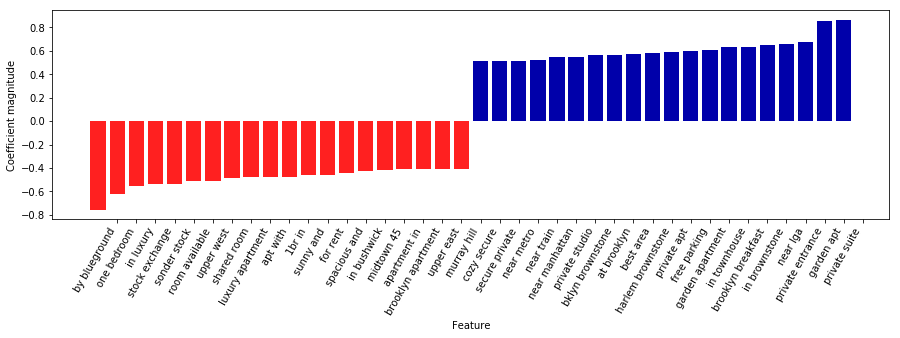

In [117]:
#plot 40 words that affect popularity most
import matplotlib.pyplot as plt
import mglearn
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=20)
plt.show()

In [118]:
len(grid.best_estimator_.coef_[0])
len(feature_names)

feature_importance_list = {a:b for a, b in zip(feature_names, grid.best_estimator_.coef_[0])}
counter =Counter(feature_importance_list)
counter.most_common(20)

5990

5990

[('private suite', 0.8630234646083246),
 ('garden apt', 0.853464039270785),
 ('private entrance', 0.6745505089559213),
 ('near lga', 0.6562762398648367),
 ('in brownstone', 0.6459840630282543),
 ('brooklyn breakfast', 0.6290319587454776),
 ('in townhouse', 0.628457920182454),
 ('garden apartment', 0.609555852071855),
 ('free parking', 0.5948658361966088),
 ('private apt', 0.5929695861703289),
 ('harlem brownstone', 0.5802281695898508),
 ('best area', 0.5757625157981124),
 ('at brooklyn', 0.5656700803706691),
 ('bklyn brownstone', 0.5635649097991917),
 ('private studio', 0.5501020875558241),
 ('near manhattan', 0.5461381102972246),
 ('near train', 0.5180301422011628),
 ('near metro', 0.5111753737168552),
 ('secure private', 0.5098131468535498),
 ('cozy secure', 0.5086702321864164)]

#### Next, we would like to conduct a comparative analysis between New York and San Francisco regarding the relationship between listing names and popularity since these two cities represent well the major cities on the east coast and west coast of U.S. 

Let's look at the Airbnb listings in San Francisco and find out which words affact popularity and price the most.

In [119]:
vect = CountVectorizer(min_df=5, ngram_range=(2, 2))
X = vect.fit(df_sf.name).transform(df_sf.name)

feature_names = vect.get_feature_names()

In [120]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X, df_sf['popular'])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

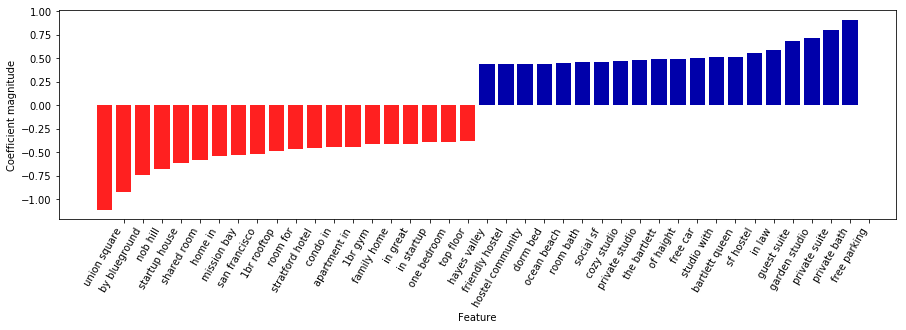

In [121]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=20)
plt.show()

In [122]:
len(grid.best_estimator_.coef_[0])
len(feature_names)

feature_importance_list = {a:b for a, b in zip(feature_names, grid.best_estimator_.coef_[0])}
counter =Counter(feature_importance_list)
counter.most_common(20)

1441

1441

[('free parking', 0.9117447748296781),
 ('private bath', 0.8067047453988045),
 ('private suite', 0.7216637883544812),
 ('garden studio', 0.6806494933321153),
 ('guest suite', 0.5920932893918723),
 ('in law', 0.5589974996917008),
 ('sf hostel', 0.5182911592164935),
 ('bartlett queen', 0.5123917162539025),
 ('studio with', 0.5005857505157733),
 ('free car', 0.4915784807752419),
 ('of haight', 0.4894514042925075),
 ('the bartlett', 0.4829546429856045),
 ('private studio', 0.4706198259045943),
 ('cozy studio', 0.45889700109606524),
 ('social sf', 0.4568282322857115),
 ('room bath', 0.45566375585029617),
 ('ocean beach', 0.4435734187783393),
 ('dorm bed', 0.4406564004003079),
 ('friendly hostel', 0.4406564004003079),
 ('hostel community', 0.4406564004003079)]

<div class="alert alert-block alert-success">
<blockquote>
<p> Conclusion:   
<ul>
From the two plots above, it is evident that Airbnb customers value privacy (e.g. Private Bath, Prviate Suite) regardless of the location while San Francisco customers favor listings with free parking on the premise, which is not a major factor for consideration for visitors of New York City.
</ul>
</p>  
</blockquote>
<blockquote>
<p> 
Managerial Suggestion:  
<ul>
For the managerial team, it would be important to prioritize the features that are location-specific in introducing or updating Airbnb listings. It is also recommended to include privacy as an attribute in the listings as it is a favorable factor for customers. 
</ul>
</p>  
</blockquote>


</div>

# <h1><center><div class="alert alert-block alert-info"> Interesting Fact 3 - Host Analysis </div></center></h1>

The first two parts of our analysis mainly focused on the actual listings. In this part, we would like switch to the host perspective to explore the NYC Airbnb dataset.

In [123]:
clu = KMeans(n_clusters=2, random_state=0)

In [124]:
X = df_clu.drop(columns = 'calculated_host_listings_count')
Y = df_clu.calculated_host_listings_count

In [125]:
clu.fit(X, sample_weight = Y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [126]:
clu.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [127]:
df6['cluster']=clu.labels_

In [128]:
df6.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,pro,cluster
0,2787,149,1,9,0.21000,6,365,0,1,0,0,0,0,1,0,0,0
1,2845,225,1,45,0.38000,2,355,0,0,1,0,0,1,0,0,0,0
2,4632,150,3,0,1.37341,1,365,0,0,1,0,0,0,1,0,0,0
3,4869,89,1,270,4.64000,1,194,0,1,0,0,0,1,0,0,0,1
4,7192,80,10,9,0.10000,1,0,0,0,1,0,0,1,0,0,0,1


In [129]:
df6.groupby('cluster').mean()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,pro
cluster,,,,,,,,,,,,,,,,
0,8.722940e+07,242.463007,11.295555,29.472117,1.564900,19.685438,300.578621,0.028275,0.336711,0.491910,0.129752,0.013352,0.587889,0.37826,0.033852,0.202325
1,6.072670e+07,121.113149,5.501895,21.100589,1.305962,2.729106,46.644148,0.020195,0.437408,0.425734,0.111047,0.005616,0.495670,0.48419,0.020140,0.023100


We noticed that the following attributes are pretty different between two clusters:

- price
- minimum_nights
- calculated_host_listings_count
- neighbourhood_group_Staten Island

*Note: The column "host_id' is not used in the clustering process. Therefore, the mean of 'host_id' here does not represent any information related to clustering. We kept this information in the dataframe just for further analysis in each cluster from host perspective.*

Given we are trying to approach from the host perspective, our analysis below will focus on the 'calculated_host_listings_count' attribute.

**1. number of listings in each cluster**

In [130]:
cluster_0 = df6[(df6.cluster == 0)]
cluster_1 = df6[(df6.cluster == 1)]
cluster_0.head()
cluster_1.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,pro,cluster
0,2787,149,1,9,0.21000,6,365,0,1,0,0,0,0,1,0,0,0
1,2845,225,1,45,0.38000,2,355,0,0,1,0,0,1,0,0,0,0
2,4632,150,3,0,1.37341,1,365,0,0,1,0,0,0,1,0,0,0
12,9744,89,4,167,1.34000,3,314,0,1,0,0,0,0,1,0,0,0
13,11528,85,2,113,0.91000,1,333,0,0,1,0,0,0,1,0,0,0


,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,pro,cluster
3,4869,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0,0,1
4,7192,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0,0,1
5,7322,200,3,74,0.59,1,129,0,0,1,0,0,1,0,0,0,1
6,7356,60,45,49,0.40,1,0,0,1,0,0,0,0,1,0,0,1
7,8967,79,2,430,3.47,1,220,0,0,1,0,0,0,1,0,0,1


In [131]:
print ('Number of Listings in Cluster 0 is ' + str(len(cluster_0)))

Number of Listings in Cluster 0 is 12732


In [132]:
print ('Number of Listings in Cluster 1 is ' + str(len(cluster_1)))

Number of Listings in Cluster 1 is 36147


We can see that the total number of listing in Cluster 0 is only 1/3 of that in Cluster 1. Meanwhile, the mean of 'calculated_host_listings_count' in Cluster 0 is almost 10 times of that in Cluster 1. We suspected that Cluster 0 has most of those listings from hosts who have extremely high number of listings.

**2. Further data exploration regarding calculated_host_listings_count** 

First, let's look at the distribution of the calculated_host_listings_count number in two clusters.

In [133]:
#Cluster 0
cluster_0.calculated_host_listings_count.describe()

count    12732.000000
mean        19.685438
std         58.551437
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

([<matplotlib.axis.XTick at 0x1a3e636890>,
 <a list of 6 Text xticklabel objects>)

Text(0.5,1,'Distribution of calculated_host_listings_coun in Cluster 0')

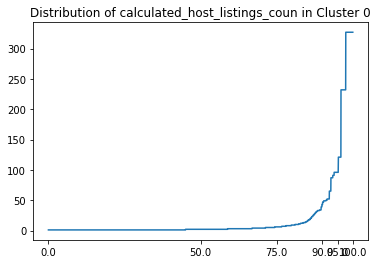

In [134]:
#Cluster 0
d = np.sort(cluster_0.calculated_host_listings_count)
p = np.array([0.0,50.0, 75.0, 90.0,95.0,100.0])
plt.plot(d)
plt.xticks((len(d)-1) * p/100., map(str, p))
plt.title('Distribution of calculated_host_listings_coun in Cluster 0')
plt.show()

In [135]:
#Cluster 0
cluster_0.calculated_host_listings_count.quantile(0.8)

9.0

In [136]:
#Cluster 1
cluster_1.calculated_host_listings_count.describe()

count    36147.000000
mean         2.729106
std         13.654689
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

([<matplotlib.axis.XTick at 0x1a49a23e90>,
 <a list of 6 Text xticklabel objects>)

Text(0.5,1,'Distribution of calculated_host_listings_coun in Cluster 1')

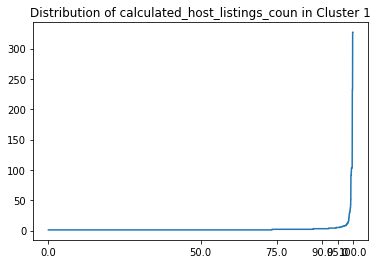

In [137]:
#Cluster 1
d = np.sort(cluster_1.calculated_host_listings_count)
p = np.array([0.0,50.0, 75.0, 90.0,95.0,100.0])
plt.plot(d)
plt.xticks((len(d)-1) * p/100., map(str, p))
plt.title('Distribution of calculated_host_listings_coun in Cluster 1')
plt.show()

In [138]:
#Cluster 1
cluster_1.calculated_host_listings_count.quantile(0.98)

10.0

Based on the results above, we confirmed that Cluster 0 has much more listings from hosts who have 9 or more listings. Let's keep digging into it.

In [139]:
((cluster_0.calculated_host_listings_count >= 9).sum()) / ((df6.calculated_host_listings_count >= 9).sum())

0.7552037525652301

It turns out that over 75% of listings from hosts who have 9 or more listing are classified as Cluster 0. Obviously, these hosts with so many listings share some similiar qualities. **These hosts with a high number of listings are not just people sharing living spcace but rather professionals.** We would proceed our analysis focusing on these professional, or "star", hosts on airbnb.

In [140]:
df6.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,pro,cluster
0,2787,149,1,9,0.21000,6,365,0,1,0,0,0,0,1,0,0,0
1,2845,225,1,45,0.38000,2,355,0,0,1,0,0,1,0,0,0,0
2,4632,150,3,0,1.37341,1,365,0,0,1,0,0,0,1,0,0,0
3,4869,89,1,270,4.64000,1,194,0,1,0,0,0,1,0,0,0,1
4,7192,80,10,9,0.10000,1,0,0,0,1,0,0,1,0,0,0,1


**3. We started our pro and non-pro analysis from price, minumum nights and neigborhood groups since they are quite different between two cluster based on our prior clustering results.**

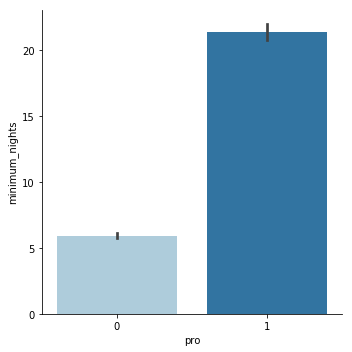

In [141]:
#in columns 'pro', 0 means non-professional hosts and 1 means professional hosts
with sns.color_palette("Paired"):
    sns.catplot(x = 'pro', y = 'minimum_nights', kind = 'bar', data = df6)

The result indicates that professional hosts usually require longer minimum booking nights. Given longer staying nights per booking will lower management costs and cleaning costs, the minumum nights preference is expected. However, why the price from professional hosts are much higher? Normally when airbnb listings with additional requirements, like longer minimum nights, the host will lower their price as trade-off.  

Let's conduct further analysis regarding the neigborhood group to see if we can anwser this question. 


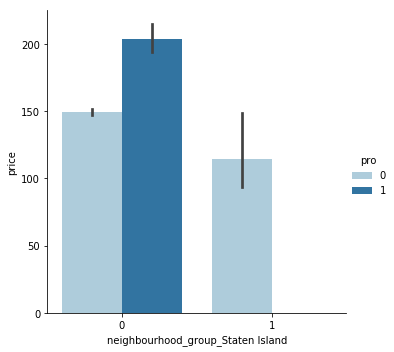

In [142]:
#in columns 'pro', 0 means non-professional hosts and 1 means professional hosts
with sns.color_palette("Paired"):
    sns.catplot(x = 'neighbourhood_group_Staten Island', y = 'price', hue = 'pro', kind = 'bar', data = df6)

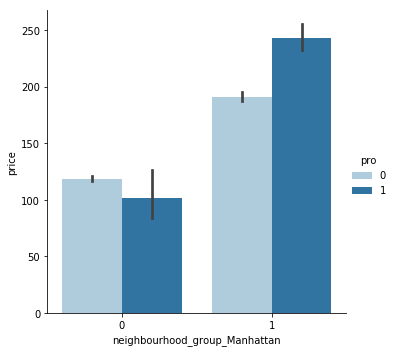

In [143]:
#in columns 'pro', 0 means non-professional hosts and 1 means professional hosts
with sns.color_palette("Paired"):
    sns.catplot(x = 'neighbourhood_group_Manhattan', y = 'price', hue = 'pro', kind = 'bar', data = df6)

In [144]:
m_pro=len(df6[(df6.pro == 1)&(df6.neighbourhood_group_Manhattan == 1)])/ len(df6[(df6.pro == 1)])
print (str(m_pro * 100) + "% of the listings from professional hosts are located in Manhattan")

71.88507768982703% of the listings from professional hosts are located in Manhattan


In [145]:
m_nonpro=len(df6[(df6.pro == 0)&(df6.neighbourhood_group_Manhattan == 1)])/ len(df6[(df6.pro == 0)])
print (str(m_nonpro * 100) + "% of the listings from non-professional hosts are located in Manhattan")

42.2275006598047% of the listings from non-professional hosts are located in Manhattan


We can see that professional hosts barely have any listings in Staten Island where is far from New York downtown and has lowest average airbnb price. Meanwhile, over 70% listings from professional hosts locate in Manhattan where is the heart of New York and has the highest average airbnb price or renting expense. Though Manhattan is the most popular for all airbnb hosts, only 42% listings from nonprofessional hosts are located in Manhattan neigborhood. 

Apart from that, for listings in Manhattan, those operated by professional hosts usually have higher price. According to our price analysis in the first section, price is highly correlated with room type. Considering that professional hosts have at least 9 listings, they usually will not live in the properties used for airbnb. So we suspected that most of the room type is "room_type_Entire home/apt" may be the reason behind the higher price.

In [146]:
room_pro=len(df6[(df6.pro == 1) & (df6['room_type_Entire home/apt'] == 1)])/len(df6[(df6.pro == 1)])
print('Percentage of listing is entire home/apt: ' + str(room_pro * 100) + "%, out of all professional host listings")

Percentage of listing is entire home/apt: 62.532981530343015%, out of all professional host listings


In [147]:
room_pro=len(df6[(df6.pro == 0) & (df6['room_type_Entire home/apt'] == 1)])/len(df6[(df6.pro == 0)])
print('Percentage of listing is entire home/apt:' + str(room_pro * 100) + "%, out of all non-professional host listings")

Percentage of listing is entire home/apt:51.17665171109351%, out of all non-professional host listings


The result above proved our hypothesis. 

In conclusion, listings from professional hosts share the following similarity:
- longer minimum night requirement
- better location: most properties are in Manhattan while almost none is in Staten Island
- room type is usually entire home/apt

At this point, the result makes us curious about the following: are they still Airbnb living-space sharing or actually short-term rentals or hotels? Are commercial real estate professionals and home rental companies using Airbnb to avoid the regulation and related taxation? Will this worsen the tight rental market and affordable housing crisis in New York?

After conducting an extensive research, we found that the New York City has realized this problem and took actions on it. In 2018, New York passed legislation designed to combat the rise of short-term rentals in the city. The regulation includes but not limited to:

- "Only owner-occupied short-term rentals are legal with a maximum of 2 paying guests who can stay at the property for fewer than 30 days."
- "Renting out entire homes, apartments, and other properties for less than 30 days is illegal even if the Airbnb host lives in the property."
- "Only rooms and parts of homes can be rented out on a short-term basis and only when the host is present during the Airbnb guests’ stays."

However, in early 2019, a federal judge blocked the New York City law intended to curb Airbnb Inc., giving a boost to the company and others that offer short-term rentals in the city. We believe that this is just a temporary victory for Airbnb. The New York City officers claimed that they will continue working on this topic. 

*Source:*                                                                                                      
https://www.mashvisor.com/blog/cities-airbnb-legal-issues-2020/
https://www.nytimes.com/2019/02/26/reader-center/airbnb-new-york-city.html
https://www.housingwire.com/articles/48226-new-york-city-escalates-fight-against-airbnb-demands-listing-information/
https://www.wired.com/story/how-9-people-built-illegal-5m-airbnb-empire-new-york/
https://www.wsj.com/articles/judge-blocks-airbnb-crackdown-in-new-york-city-11546560423
https://www.vox.com/the-goods/2019/1/9/18174095/airbnb-lawsuit-new-york-city

<div class="alert alert-block alert-success">
<blockquote>
<p> Conclusion:   
<ul>
Some professional real estates and hospitality companies are operating their real estate properties as Airbnb listings, gaining additional profits because of the prime locations of their properties.  
</ul>
</p>  
</blockquote>
<blockquote>
<p> 
Managerial Suggestion:  
<ul>
For real estate and hospitality companies, it is recommended that they list their properties that are located in prime locations in New York City through Airbnb listings because it will be likely to generate more revenue. 
</ul>
</p>  
</blockquote>


</div>